<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Алгоритмы кластеризации (практика)</center></h2>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

[Данные](https://cloud.mail.ru/public/GeB1/w8nWkQyd1)

# Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

* Подготовте данные к кластеризации и сделайте иерарническую кластеризацию этого набора данных.
* Изобразите дендрограмму
* Выверите число кластеров и интерпретируйте их

Почему перед применением кластеризации признки необходимо нормализовать?

In [23]:
## Your Code Here

# Европейcкие языки

Загризите данные из файла `'languages.txt'` о произношении различных слов на европейских языках.

Используйте расстояние Левенштейна, чтобы рассчитать близость языков по данным словам

Для этого вам надо написать собственную функцию, которая принимает на вход вектора двух объектов и считает расстояние между ними.

Как в дальнейшем использовать вашу функцию можно посмотреть [здесь](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html) в п.23 (если вы будете использовать `scipy`)  или передать на вход в `AgglomerativeClustering` в `sklearn`.

In [24]:
def classic_levenshtein(string_1, string_2):
    '''
    Расстояние Левенштейна
    '''
    len_1 = len(string_1)
    len_2 = len(string_2)
    cost = 0

    if len_1 and len_2 and string_1[0] != string_2[0]:
        cost = 1

    if len_1 == 0:
        return len_2
    elif len_2 == 0:
        return len_1
    else:
        return min(
            classic_levenshtein(string_1[1:], string_2) + 1,
            classic_levenshtein(string_1, string_2[1:]) + 1,
            classic_levenshtein(string_1[1:], string_2[1:]) + cost,
)

In [25]:
classic_levenshtein('мгу', 'вмк')

4

In [26]:
## Your Code Here

## DBSCAN и геоданные

Загрузите геоданные из `geo_data.txt.gz` (uid, timestamp, lat, lon, location_id).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [27]:
#import mpl_toolkits.basemap as bm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [28]:
df_geo = pd.read_csv('geo_data.txt', sep='\t', header=None,
                     names=['lat', 'lon'])/10000

In [29]:
df_geo.head()

,lat,lon
0,62.5983,29.7439
1,62.6146,29.7440
2,62.6144,29.7456
3,62.6004,29.7394
4,62.6018,29.7437


In [30]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print 'что-то пошло не так'
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

что-то пошло не так


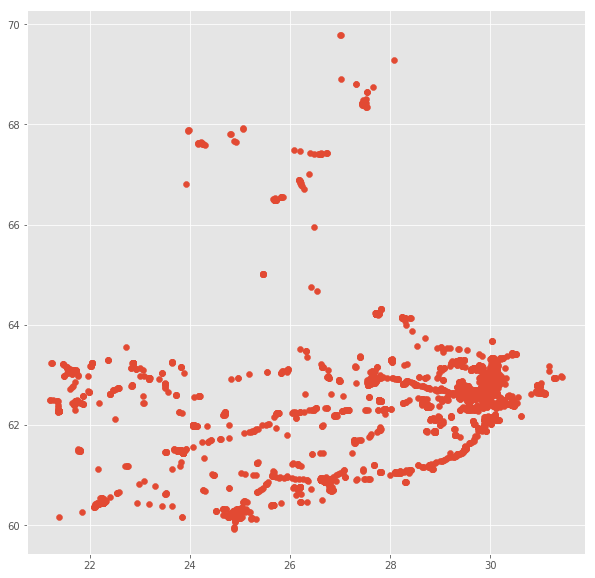

In [31]:
plot_geo(df_geo.lat.values, df_geo.lon.values)

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [32]:
km_in_radian = 6371.0088
X = np.radians(df_geo.values)
X

array([[ 1.09254644,  0.51912899],
       [ 1.09283093,  0.51913073],
       [ 1.09282744,  0.51915866],
       ..., 
       [ 1.09266338,  0.5190679 ],
       [ 1.09256739,  0.5191063 ],
       [ 1.0925447 ,  0.51911502]])

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше (например MinPts = 20). Воспользуемся эвристикой, схожей с методом локтя для оценки eps:

* Расчитайте среднее расстояние до k=MinPts ближайших соседей каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* Выберите такое расстояние, где будет наблюдаться "перегиб"

In [33]:
nn = NearestNeighbors(n_neighbors=20, algorithm='ball_tree', metric='haversine')
nn.fit(X)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='haversine',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [48]:
dist, ind = nn.kneighbors(X, n_neighbors=21, return_distance=True)

In [49]:
mean_dist = dist[:, 1:].mean(axis=1)

In [50]:
mean_dist = np.sort(mean_dist)

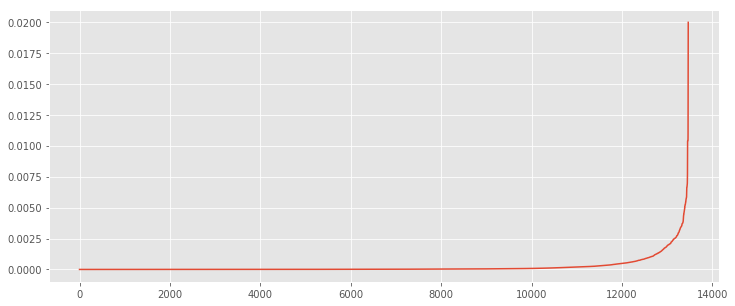

In [51]:
plt.plot(mean_dist)

Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Изобразите координаты точек, не попавших в кластер выбросов (метка -1)

In [67]:
dbscan = DBSCAN(eps=0.0025, min_samples=20, metric='haversine', algorithm='ball_tree')
dbscan.fit(X)
Y = dbscan.labels_
## Your Code Here

In [68]:
pd.Series(Y).value_counts()

 0     10897
-1       424
 3       337
 9       305
 1       250
 2       163
 5       153
 7       138
 14      117
 12       93
 8        81
 11       57
 10       47
 23       39
 20       39
 18       37
 21       37
 6        34
 15       27
 16       26
 22       26
 19       25
 13       24
 25       24
 24       24
 17       22
 4        21
dtype: int64

что-то пошло не так


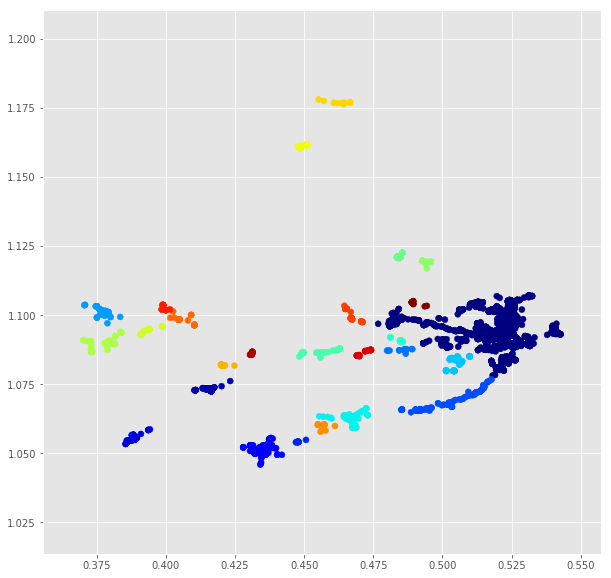

In [75]:
idx = Y != -1
plot_geo(X[idx, 0], X[idx, 1], Y[idx])